###Imports

In [ ]:
# Importing yfinance sometimes doesnt work well so we used try/except..
try:
  import yfinance as yf
except ImportError:
  !pip install yfinance
  import yfinance as yf 
  print("\nDone Importing...'")

     |████████████████████████████████| 6.3 MB 8.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=8714e8a82d5da42008d93c25ede220005b02b846d86ba480e742d7436be0703b
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6

Done Importing...'


In [ ]:
# Import usefull libraries
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
import seaborn as sns
from torch.autograd import Variable
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional

print('Done Importing...\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


Done Importing...



###Download chosen stock ticker's data

In [ ]:
# Define stock ticker as input so user can choose out of a few options
df = pd.DataFrame()
print("Optional tickers with enough price history for stock price prediction: CHKP, BRK-B, IBM")
chosen_ticker = str(input("Please enter a stock ticker from the given options above ")).upper()
print('{0} : {1}'.format('\nYour chosen ticker is', chosen_ticker))

# Stock prices date time range
start_date = '2010-01-01'
end_date = '2021-08-15'

ticker_data = yf.Ticker(chosen_ticker)
stock_data1 = yf.download(chosen_ticker, start_date, end_date)

Optional tickers with enough price history for stock price prediction: CHKP, BRK-B, IBM
Please enter a stock ticker from the given options above chkp

Your chosen ticker is : CHKP
[*********************100%***********************]  1 of 1 completed


###Understand the data

In [ ]:
# Get a sense of how the raw data looks like
stock_data1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,34.320000,34.389999,33.959999,34.110001,34.110001,1270500
2010-01-05,33.560001,33.869999,32.750000,33.820000,33.820000,3147500
2010-01-06,33.849998,34.369999,33.709999,34.000000,34.000000,2330900
2010-01-07,34.130001,34.130001,33.770000,33.919998,33.919998,1614100
2010-01-08,33.770000,33.970001,33.549999,33.590000,33.590000,1773400


In [ ]:
# In this project we chose to use only the closing price adjust to stock splits as the predictable feature
stock_data = stock_data1["Adj Close"]
stock_data = pd.DataFrame(stock_data)
stock_data.reset_index()

,Date,Adj Close
0,2010-01-04,34.110001
1,2010-01-05,33.820000
2,2010-01-06,34.000000
3,2010-01-07,33.919998
4,2010-01-08,33.590000
...,...,...
2919,2021-08-09,123.760002
2920,2021-08-10,123.050003
2921,2021-08-11,122.489998
2922,2021-08-12,122.459999


In [ ]:
stock_data.describe()

,Adj Close
count,2924.000000
mean,81.054641
std,28.449281
min,29.170000
25%,54.905000
50%,80.900002
75%,108.267500
max,137.589996


###Raw data visualisation

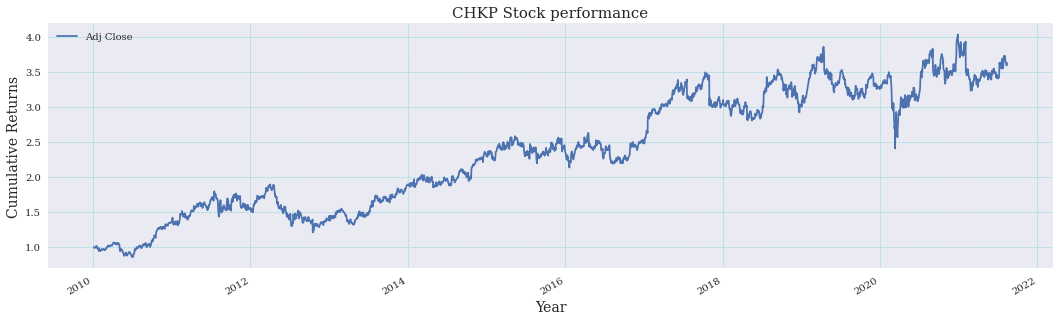

In [ ]:
# Plot the chosen Stock performance (%)
((stock_data.pct_change()+1).cumprod()).plot(figsize=(18, 5))
plt.legend()
plt.title('{0} {1}'.format(chosen_ticker, "Stock performance"),fontsize=15)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(which="major", color='c', linestyle=':', linewidth=0.5)
plt.show()

In [ ]:
stock_data = stock_data.reset_index()
stock_data = pd.DataFrame(stock_data['Adj Close'])
stock_data.head()

,Adj Close
0,34.110001
1,33.820000
2,34.000000
3,33.919998
4,33.590000


In [ ]:
# Normalising the data
scaler = MinMaxScaler(feature_range=(-1, 1))
stock_data['Adj Close'] = scaler.fit_transform(stock_data['Adj Close'].values.reshape(-1,1))

###Split the raw data to train and test while using lookback sequence

In [ ]:
def split_data(stock_data, lookback):
    data_raw = stock_data.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # sequence length 
x_train, y_train, x_test, y_test = split_data(stock_data, lookback)

In [ ]:
# self check
print('x_train.shape:',x_train.shape,
      '\ny_train.shape:', y_train.shape, # 2323 observations
      '\nx_test.shape:', x_test.shape,
      '\ny_test.shape:', y_test.shape,
      '\nraw data.shape:', stock_data.shape
      )

x_train.shape: (2323, 19, 1) 
y_train.shape: (2323, 1) 
x_test.shape: (581, 19, 1) 
y_test.shape: (581, 1) 
raw data.shape: (2924, 1)


###Transform raw data to tensor


In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

##Define LSTM & GRU model params

In [ ]:
# Define LSTM params (by rule of thumb, grid search takes too long)
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 101 # we checked with different numbers of epochs - 100\500\1000 

##Build LSTM model using defined params from above


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

##LSTM model using MSE loss function and Adam optimizer

In [ ]:
model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim,
             num_layers = num_layers)
criterion = torch.nn.MSELoss(reduction='mean') # MSE Loss function
optimiser = torch.optim.Adam(model.parameters(), lr = 0.001) # Adam optimizer

##Train LSTM model

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if epoch % 10 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time_LSTM = time.time() - start_time
print("\nTraining time LSTM: {}".format(training_time_LSTM),"seconds.")

Epoch  0 MSE:  0.269843727350235
Epoch  10 MSE:  0.20478269457817078
Epoch  20 MSE:  0.171099454164505
Epoch  30 MSE:  0.11331438273191452
Epoch  40 MSE:  0.023989053443074226
Epoch  50 MSE:  0.01995762623846531
Epoch  60 MSE:  0.006252232939004898
Epoch  70 MSE:  0.0034988175611943007
Epoch  80 MSE:  0.003461250336840749
Epoch  90 MSE:  0.003028220497071743
Epoch  100 MSE:  0.00265697855502367

Training time LSTM: 29.816899061203003 seconds.


Inverse the normalization

In [ ]:
predict_train = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original_train = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

##Visualisation  of training results - LSTM model

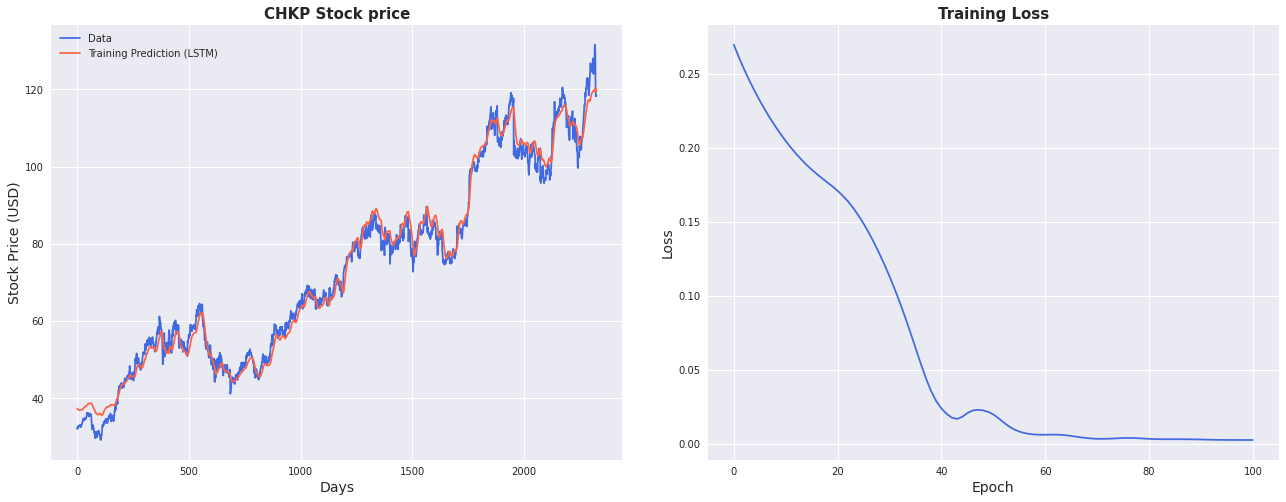

In [ ]:
# Plot the training results
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.15, wspace=0.15)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_train.index, y = original_train[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_train.index, y = predict_train[0], label="Training Prediction (LSTM)", color='tomato')
plt.title('{0} {1}'.format(chosen_ticker, "Stock price"),fontsize=15, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Stock Price (USD)", size = 14)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 15, fontweight='bold')
fig.set_figheight(8)
fig.set_figwidth(22)
#plt.xlim(80,1000)
#plt.ylim(0,0.01)

##Prediction results - LSTM model

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions back to normal values
predict_test = scaler.inverse_transform(y_test_pred.detach().numpy())
original_test = scaler.inverse_transform(y_test_lstm.detach().numpy())
predict_train = scaler.inverse_transform(y_train_pred.detach().numpy())
original_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

# calculate mean squared error
trainScore = mean_squared_error(original_train[:,0], predict_train[:,0])
print('Train Score: %.2f MSE($)' % (trainScore))
testScore = mean_squared_error(original_test[:,0], predict_test[:,0])
print('Test Score: %.2f MSE($)' % (testScore))
print('Training time for LSTM model: %.2f sec' % (training_time_LSTM))

Train Score: 7.81 MSE($)
Test Score: 21.89 MSE($)
Training time for LSTM model: 29.82 sec


In [ ]:
original_train = pd.DataFrame(original_train)
predict_train = pd.DataFrame(predict_train)
original_test = pd.DataFrame(original_test)
predict_test = pd.DataFrame(predict_test)

In [ ]:
#len(original_train)

In [ ]:
stock_data = scaler.inverse_transform(stock_data)
stock_data = pd.DataFrame(stock_data)

In [ ]:
stock_data.rename(columns = {0:"Price"}, inplace = True)
stock_data.head(5)

,Price
0,34.110001
1,33.820000
2,34.000000
3,33.919998
4,33.590000


In [ ]:
predict_test1 = predict_test
predict_test1.index = np.arange(2323, len(predict_test1)+2323) # 2323 length of original data

In [ ]:
train = stock_data[:2323] # 2323 obs
valid = stock_data[2323:]
#valid = valid.reset_index()
valid['Predictions'] = predict_test1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
valid.head()

,Price,Predictions
2323,124.830002,118.933403
2324,126.489998,118.515511
2325,126.800003,118.157097
2326,127.989998,117.895721
2327,127.800003,117.693626


##Visualising predictions vs original data - LSTM model

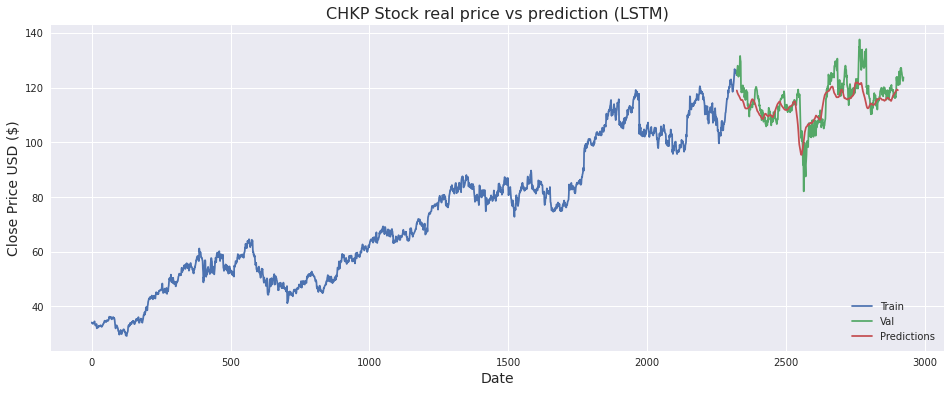

In [ ]:
# Visualize the  prediction vs original data
plt.figure(figsize=(16,6))
plt.title('{0} {1}'.format(chosen_ticker, "Stock real price vs prediction (LSTM)"),fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train[0:])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

#GRU Model

##Build GRU model using defined params from above


In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out        

In [ ]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion_gru = torch.nn.MSELoss(reduction='mean')
optimiser_gru = torch.optim.Adam(model_gru.parameters(), lr = 0.001)

##Train GRU model

In [ ]:
hist_gru = np.zeros(num_epochs)
start_time = time.time()
gru = []

for epoch in range(num_epochs):
    y_train_pred_gru = model_gru(x_train)

    loss = criterion_gru(y_train_pred_gru, y_train_gru)
    if epoch % 10 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    hist_gru[epoch] = loss.item()

    optimiser_gru.zero_grad()
    loss.backward()
    optimiser_gru.step()

training_time_GRU = time.time() - start_time    
print("Training time GRU model: {}".format(training_time_GRU))

Epoch  0 MSE:  0.21517738699913025
Epoch  10 MSE:  0.14837101101875305
Epoch  20 MSE:  0.06246203929185867
Epoch  30 MSE:  0.005287550389766693
Epoch  40 MSE:  0.0016297638649120927
Epoch  50 MSE:  0.0038385256193578243
Epoch  60 MSE:  0.0014815713511779904
Epoch  70 MSE:  0.001258108182810247
Epoch  80 MSE:  0.0012973654083907604
Epoch  90 MSE:  0.001191558432765305
Epoch  100 MSE:  0.0011393593158572912
Training time GRU model: 23.25119137763977


In [ ]:
predict_gru = pd.DataFrame(scaler.inverse_transform(y_train_pred_gru.detach().numpy()))
original_gru = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

##Visualisation training results GRU model

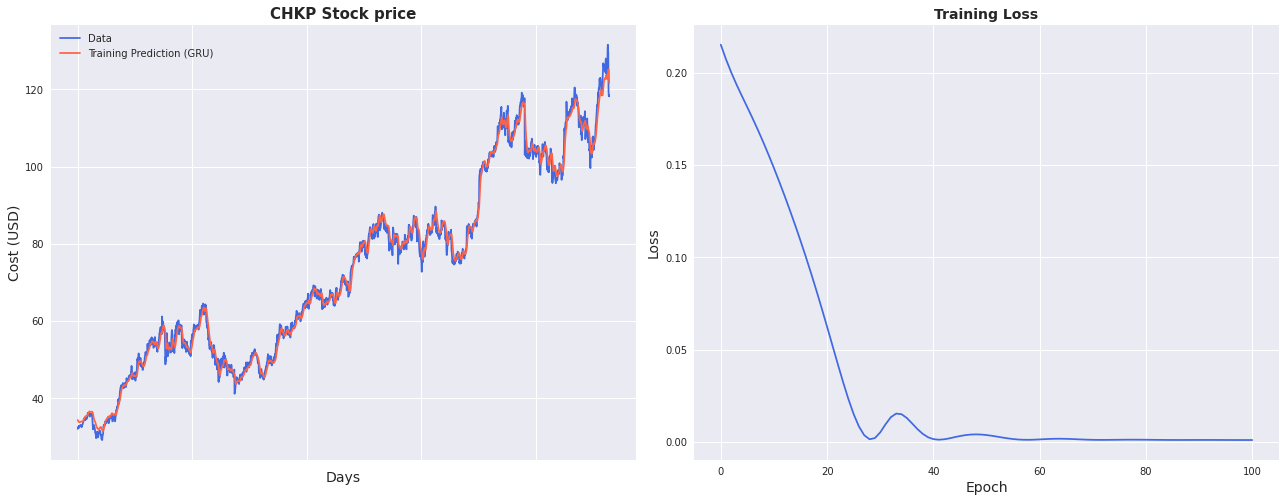

In [ ]:
sns.set_style("darkgrid") 
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.1)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_gru.index, y = original_gru[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_gru.index, y = predict_gru[0], label="Training Prediction (GRU)", color='tomato')
plt.title('{0} {1}'.format(chosen_ticker, "Stock price"),fontsize=15, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist_gru, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(8)
fig.set_figwidth(22)

###Inverse normalisation and print MSE & Traning time results

In [ ]:
# model predictions
y_test_pred_gru = model_gru(x_test)

# invert predictions from scaled DF
y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru.detach().numpy())
y_test_gru = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate mean squared error
trainScore_gru = mean_squared_error(y_train_gru[:,0], y_train_pred_gru[:,0])
print('Train Score: %.2f MSE($)' % (trainScore_gru))
testScore_gru = mean_squared_error(y_test_gru[:,0], y_test_pred_gru[:,0])
print('Test Score: %.2f MSE($)' % (testScore_gru))
print('Training time for GRU model: %.2f sec' % (training_time_GRU))

Train Score: 3.35 MSE($)
Test Score: 10.40 MSE($)
Training time for GRU model: 23.25 sec


In [ ]:
original_train_gru = pd.DataFrame(y_train_gru)
predict_train_gru = pd.DataFrame(y_train_pred_gru)
original_test_gru = pd.DataFrame(y_test_gru)
predict_test_gru = pd.DataFrame(y_test_pred_gru)

In [ ]:
predict_test1_gru = predict_test_gru
predict_test1_gru.index = np.arange(2323, len(predict_test1_gru)+2323) # 2323 as the train length 

In [ ]:
train_gru = stock_data[:2323]
valid_gru = stock_data[2324:]
#valid = valid.reset_index()
valid_gru['Predictions'] = predict_test1_gru

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#valid_gru.head()
valid_gru.head(5)

,Price,Predictions
2324,126.489998,119.623825
2325,126.800003,119.096497
2326,127.989998,118.892029
2327,127.800003,118.832657
2328,124.220001,118.586746


##Visualisation of prediction vs original data - GRU model

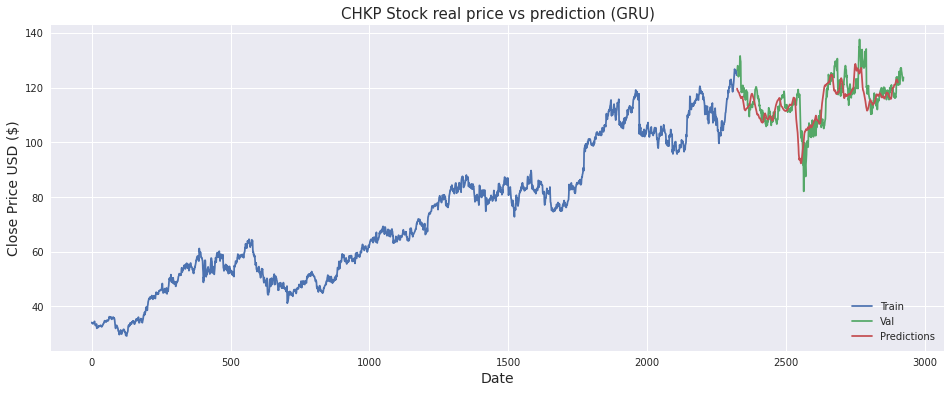

In [ ]:
plt.figure(figsize=(16,6))
plt.title('{0} {1}'.format(chosen_ticker, "Stock real price vs prediction (GRU)",fontsize=16 )
,fontsize=15)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train_gru[0:])
plt.plot(valid_gru[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()